# Stroke Prediction Dataset

### Import

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as py
import plotly.express as px
from plotly.subplots import make_subplots
py.init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Load data

In [29]:
# caricamento dati
df = pd.read_csv('./healthcare-dataset-stroke-data.csv')
# dimensioni
nRow, nCol = df.shape
print('Le dimensioni del dataframe sono:')
print(nRow, nCol)

# nomi delle colonne
print(df.columns)

Le dimensioni del dataframe sono:
5110 12
Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


### Data cleaning

In [30]:
# salvo una copia
dfOriginal = df.copy()

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [32]:
# rinomino colonne
df.rename(columns = {'Residence_type':'residence_type'}, inplace = True)
columnNames = df.columns.tolist()
columnNames

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [33]:
# trovo i valori NaN
for i in columnNames:
    print(str(i) + ' has: ' + str(df[i].isnull().values.sum()) + ' NaN values')
# BMI ha dei valori mancanti

id has: 0 NaN values
gender has: 0 NaN values
age has: 0 NaN values
hypertension has: 0 NaN values
heart_disease has: 0 NaN values
ever_married has: 0 NaN values
work_type has: 0 NaN values
residence_type has: 0 NaN values
avg_glucose_level has: 0 NaN values
bmi has: 201 NaN values
smoking_status has: 0 NaN values
stroke has: 0 NaN values


In [34]:
# rimuovo tutti i NaN presenti dal dataframe (in questo caso solo dalla colonna BMI)
df = df.dropna() # rimuove 201 righe
# rimuovo tutti i soggetti con età inferiore a 14 (età in cui è visibile il primo stroke = 1)
df = df[df.age >= 14] # rimuove 629 righe
# rimuovo il soggetto in cui non è specificato il genere
df = df[df.gender != 'Other'] # Rimuove 1 riga
df.reset_index(inplace=True, drop=True)
df.index

RangeIndex(start=0, stop=4279, step=1)

In [35]:
# nuove dimensioni
nRow, nCol = df.shape
print('Le dimensioni del dataframe pulito sono:')
print(nRow, nCol)

Le dimensioni del dataframe pulito sono:
4279 12


### Prima analisi delle variabili numeriche

In [36]:
# rimuovo le colonne degli ID e degli index per una visualizzazione grafica migliore
df_noID = df.copy().drop(columns=['id'])
df_noID.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4279.000000,4279.000000,4279.000000,4279.000000,4279.000000,4279.000000
mean,48.244917,0.105398,0.056555,107.045501,30.244426,0.048843
std,18.856036,0.307102,0.231018,46.320139,7.335979,0.215565
min,14.000000,0.000000,0.000000,55.120000,11.300000,0.000000
25%,33.000000,0.000000,0.000000,77.235000,25.100000,0.000000
50%,49.000000,0.000000,0.000000,91.980000,29.000000,0.000000
75%,63.000000,0.000000,0.000000,115.050000,34.000000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


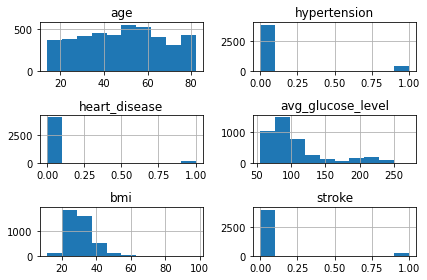

In [37]:
df_noID.hist(bins = 10)
plt.tight_layout()
plt.show()

In [38]:
# trovo i valori 'unique' per ogni colonna
for i in columnNames:
    if i == 'id' or i == 'index' or i == 'age' or i == 'bmi' or i == 'avg_glucose_level':
        pass
    else:
        print(str(i) + ' has: ' + str(pd.unique(df[i])) + ' unique values\n')

gender has: ['Male' 'Female'] unique values

hypertension has: [0 1] unique values

heart_disease has: [1 0] unique values

ever_married has: ['Yes' 'No'] unique values

work_type has: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked'] unique values

residence_type has: ['Urban' 'Rural'] unique values

smoking_status has: ['formerly smoked' 'never smoked' 'smokes' 'Unknown'] unique values

stroke has: [1 0] unique values



# Analisi sull'incidenza di ipertensione
Plotto la distribuzione del genere all'interno del dataset, la distribuzione dei soggetti che hanno riportato ipertensione e la distribuzione di quest'ultima all'interno delle due classi di genere.

Si può notare che il dataset include una leggera maggioranza di donne, l'incidenza di ipetensione è molto sbilanciata rispetto al dataset completo (solo 10.5% del totale) e che è leggermente più presente nel subset di soggetti maschili nonstante siano in numero minore.

Numero di soggetti che riportano ipertensione sul totale di soggetti (4279):

In [39]:
df.query('hypertension==1').count()['hypertension']

451

Numero di soggetti di genere femminile che riportano ipertensione sul totale di soggetti femminili (2599):

In [40]:
df[df.gender == 'Female'].query('hypertension==1').count()['hypertension']

251

Numero di soggetti di genere maschile che riportano ipertensione sul totale di soggetti maschili (1680):

In [41]:
df[df.gender == 'Male'].query('hypertension==1').count()['hypertension']

200

In [42]:
fig = make_subplots(
    rows=2, cols=2,subplot_titles=('<b>Distribution of <i>Genders</i></b>','<b>Distribution of <i>Hypertension</i></b>','<b><i>Hypertension</i> of Male Subjects</b>','<b><i>Hypertension</i> of Female Subjects</b>'),
    vertical_spacing=0.09,
    specs=[[{"type": "pie","colspan": 1}       ,{"type": "pie","colspan": 1}],
           [{"type": "pie","rowspan": 1}       ,{"type": "pie","rowspan": 1}],                                      
          ]
)

fig.add_trace(
    go.Pie(values=df.gender.value_counts().values,labels=['Donne','Uomini'],hole=0.5,pull=[0,0.02,0.5],marker_colors=['lightpink','lightblue'],textposition='inside'
          ),
    row=1, col=1
)

fig.add_trace(
    go.Pie(values=df.hypertension.value_counts().values,labels=['No Hypertension','Hypertension'],hole=0.5,pull=[0,0.02,0.5],marker_colors=['lightgreen','red'],textposition='inside'
          ),
    row=1, col=2
)

fig.add_trace(
    go.Pie(values=df.query('gender=="Male"').hypertension.value_counts().values,labels=['No Hypertension','Hypertension'],hole=0,pull=[0,0.02,0.5],marker_colors=['lightgreen','red'],textposition='inside'
          ),
    row=2, col=1
)

fig.add_trace(
    go.Pie(values=df.query('gender=="Female"').hypertension.value_counts().values,labels=['No Hypertension','Hypertension'],hole=0,pull=[0,0.02,0.5],marker_colors=['lightgreen','red'],textposition='inside'
          ),
    row=2, col=2
)

fig.update_layout(
    height=800,
    showlegend=True,
    title_text="<b>Gender and Hypertension<b>"
)

fig.show()

A questo punto plotto la distribuzione delle età dei soggetti del dataset all'interno di un istogramma evidenziando in rosso l'incidenza di ipertensione i base all'età.

In [43]:
age_distr = px.histogram(
        df,x=df.age,color="hypertension",title='<b>Age distribution</b>',color_discrete_sequence=px.colors.qualitative.G10#Dark2
    )
age_distr.show()

L'età media dei soggetti è:

In [44]:
df.age.mean().round(2)

48.24

L'età media dei soggetti che riportano ipertensione è:

In [45]:
df.query('hypertension==1').mean()['age'].round(2)

62.32

### Categorie in base all'indice di massa corporea (BMI)
Calcolo le categorie di appartenenza sulla base del valore di BMI e le inserisco in una nuova colonna del dataframe.

In [46]:
bmi_g = []
for i in df['bmi']:
    if i > 30:
        bmi_g.append('obesità')
    elif i <= 30 and i >= 25:
        bmi_g.append('sovrappeso')
    elif i < 25 and i >= 18.5:
        bmi_g.append('normopeso')
    elif i < 18.5:
        bmi_g.append('sottopeso')

In [47]:
df['bmi_group']=pd.Series(bmi_g)
df.sort_values('id')#.drop(columns=['index'])

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_group
862,84,Male,55.0,0,0,Yes,Private,Urban,89.17,31.5,never smoked,0,obesità
2113,91,Female,42.0,0,0,No,Private,Urban,98.53,18.5,never smoked,0,normopeso
693,99,Female,31.0,0,0,No,Private,Urban,108.89,52.3,Unknown,0,obesità
357,129,Female,24.0,0,0,No,Private,Urban,97.55,26.2,never smoked,0,sovrappeso
969,156,Female,33.0,0,0,Yes,Private,Rural,86.97,42.2,never smoked,0,obesità
...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,72882,Male,47.0,0,0,Yes,Private,Rural,75.30,25.0,formerly smoked,0,sovrappeso
228,72911,Female,57.0,1,0,Yes,Private,Rural,129.54,60.9,smokes,0,obesità
4260,72914,Female,19.0,0,0,No,Private,Urban,90.57,24.2,Unknown,0,normopeso
2198,72915,Female,45.0,0,0,Yes,Private,Urban,172.33,45.3,formerly smoked,0,obesità


### Categorie in base alla media del livello di glucosio
Calcolo le categorie di appartenenza sulla base del valore medio del livello di glucosio e le inserisco in una nuova colonna del dataframe.

In [48]:
glucose_g = []
for i in df['avg_glucose_level']:
    if i < 60:
        glucose_g.append('ipoglicemia')
    elif i >= 60 and i <= 110:
        glucose_g.append('normale')
    elif i >= 110:
        glucose_g.append('iperglicemia')

In [49]:
df['glucose_group']=pd.Series(glucose_g)
df.sort_values('id')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_group,glucose_group
862,84,Male,55.0,0,0,Yes,Private,Urban,89.17,31.5,never smoked,0,obesità,normale
2113,91,Female,42.0,0,0,No,Private,Urban,98.53,18.5,never smoked,0,normopeso,normale
693,99,Female,31.0,0,0,No,Private,Urban,108.89,52.3,Unknown,0,obesità,normale
357,129,Female,24.0,0,0,No,Private,Urban,97.55,26.2,never smoked,0,sovrappeso,normale
969,156,Female,33.0,0,0,Yes,Private,Rural,86.97,42.2,never smoked,0,obesità,normale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,72882,Male,47.0,0,0,Yes,Private,Rural,75.30,25.0,formerly smoked,0,sovrappeso,normale
228,72911,Female,57.0,1,0,Yes,Private,Rural,129.54,60.9,smokes,0,obesità,iperglicemia
4260,72914,Female,19.0,0,0,No,Private,Urban,90.57,24.2,Unknown,0,normopeso,normale
2198,72915,Female,45.0,0,0,Yes,Private,Urban,172.33,45.3,formerly smoked,0,obesità,iperglicemia


### Categorie in base all'età'
Calcolo le categorie di appartenenza sulla base dell'età e le inserisco in una nuova colonna del dataframe.

In [50]:
age_g = []
for i in df['age']:
    if i < 35:
        age_g.append('giovane')
    elif i >= 35 and i <= 55:
        age_g.append('adulto')
    elif i >= 55:
        age_g.append('anziano')

In [51]:
df['age_group']=pd.Series(age_g)
df.sort_values('id')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_group,glucose_group,age_group
862,84,Male,55.0,0,0,Yes,Private,Urban,89.17,31.5,never smoked,0,obesità,normale,adulto
2113,91,Female,42.0,0,0,No,Private,Urban,98.53,18.5,never smoked,0,normopeso,normale,adulto
693,99,Female,31.0,0,0,No,Private,Urban,108.89,52.3,Unknown,0,obesità,normale,giovane
357,129,Female,24.0,0,0,No,Private,Urban,97.55,26.2,never smoked,0,sovrappeso,normale,giovane
969,156,Female,33.0,0,0,Yes,Private,Rural,86.97,42.2,never smoked,0,obesità,normale,giovane
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,72882,Male,47.0,0,0,Yes,Private,Rural,75.30,25.0,formerly smoked,0,sovrappeso,normale,adulto
228,72911,Female,57.0,1,0,Yes,Private,Rural,129.54,60.9,smokes,0,obesità,iperglicemia,anziano
4260,72914,Female,19.0,0,0,No,Private,Urban,90.57,24.2,Unknown,0,normopeso,normale,giovane
2198,72915,Female,45.0,0,0,Yes,Private,Urban,172.33,45.3,formerly smoked,0,obesità,iperglicemia,adulto


In [52]:
# aggiorno la lista delle colonne
columnNames = df.columns.tolist()
columnNames

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke',
 'bmi_group',
 'glucose_group',
 'age_group']

Ciclo for per creare tutte le coppie di immagini:

In [53]:
for i in columnNames:
    if i != 'id' and i != 'bmi' and i != 'age' and i != 'hypertension' and i != 'avg_glucose_level':
        fig = px.histogram(
        df,x=df[str(i)],color='hypertension',title=('<b>Hypertension - '+str(i)+' relation</b>'),color_discrete_sequence=px.colors.qualitative.Pastel2
        )
        fig.show()

Non si nota un particolare comportamento prevalente per distinguere in modo evidente le due classi di ipertensione.
L'unico aspetto evidente è che l'ipertensione si presenta soprattutto nei soggetti con età maggiore.

Per vedere tutti i plot incrociati per tutti gli attributi decommentare la seguente cella:

In [54]:
#for i in columnNames:
#    for j in columnNames:
#        if i != 'id' and i != 'bmi' and i != 'age' and j != 'id' and j != 'bmi' and j != 'age' and i != j:
#            fig = px.histogram(
#            df,x=df.bmi_group,color=str(i),title=('<b>BMI-'+str(i)+' relation</b>'),color_discrete_sequence=px.colors.qualitative.Pastel2
#            )
#        fig.show()

### Resampling
Poichè il dataset è molto sbilanciato è bene ricampionare i dati. Per evitare di sovracampionare e rendere meno realistica la previsione, si decide di utilizzare un sottogruppo di campioni che riportano un target pari a 0 e la totalità dei campioni che hanno target pari a 1:

Nuovo set di campioni con target pari a 1:

In [55]:
resampled1 = resample(df.query('hypertension==1'), replace=True, n_samples=400, random_state=None, stratify=None)
resampled1.shape

(400, 15)

Nuovo set di campioni con target pari a 0:

In [56]:
resampled0 = resample(df.query('hypertension!=1'), replace=True, n_samples=1200, random_state=None, stratify=None)
resampled0.shape

(1200, 15)

Nuovo set di campioni completo:

In [57]:
frames = [resampled0, resampled1]

resampled = pd.concat(frames)

resampled.shape

(1600, 15)

In [58]:
# converto i valori stringa in numerici
resampled.gender = resampled.gender.replace({'Male':0,'Female':1}).astype(np.uint8)
resampled.ever_married = resampled.ever_married.replace({'No':0,'Yes':1}).astype(np.uint8)
resampled.residence_type = resampled.residence_type.replace({'Rural':0,'Urban':1}).astype(np.uint8)
resampled.work_type = resampled.work_type.replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)
resampled.smoking_status = resampled.smoking_status.replace({'Unknown':-1,'never smoked':0,'formerly smoked':1,'smokes':2}).astype(np.uint8)
resampled.bmi_group = resampled.bmi_group.replace({'sottopeso':-1,'normopeso':0,'sovrappeso':1,'obesità':2}).astype(np.uint8)
resampled.glucose_group = resampled.glucose_group.replace({'ipoglicemia':-1,'normale':0,'iperglicemia':1}).astype(np.uint8)
resampled.age_group = resampled.age_group.replace({'giovane':0,'adulto':1,'anziano':2}).astype(np.uint8)

resampled

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_group,glucose_group,age_group
1053,59878,1,56.0,0,0,1,1,1,124.16,23.0,0,0,0,1,2
1612,727,0,44.0,0,0,1,0,0,95.46,31.4,2,0,2,0,1
1546,70654,1,25.0,0,0,0,0,0,100.82,31.9,255,0,2,0,0
3370,46343,1,79.0,0,0,1,0,1,71.46,33.4,255,0,2,0,2
398,5835,0,68.0,0,0,1,0,1,92.21,27.3,255,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2690,54177,1,49.0,1,0,1,2,0,63.16,23.3,1,0,0,0,1
1395,48072,1,53.0,1,0,1,0,1,151.56,28.5,255,0,1,1,1
1309,36679,1,22.0,1,0,0,0,1,71.22,40.0,0,0,2,0,0
1371,53909,1,53.0,1,0,1,0,1,202.66,34.1,2,0,2,1,1


Utilizzo la funzione train_test_split per dividere i campioi in train e test set, untilizzando l'attributo 'stratify' che permette di mantenere la proporzione originale di campioni con etichetta 0 o 1 (quindi 1:3 in questo caso).

## Caso 1

Caso 1:
Utilizzo le seguenti colonne di attributi per l'analisi:
- 'gender'
- 'heart_disease'
- 'ever_married'
- 'work_type'
- 'residence_type'
- 'smoking_status'
- 'stroke'
- 'bmi_group'
- 'glucose_group'
- 'age_group'

NB: non utilizzo le colonne 'bmi', 'avg_glucose_level' e 'age' che hanno dei valori puntuali ma utilizzo i loro corrispettivi gruppi 'bmi_group', 'glucose_group' e 'age_group'.

In [70]:
X = resampled[['gender', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'stroke', 'bmi_group', 'glucose_group', 'age_group']]
y = resampled['hypertension']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.30, random_state=1, shuffle=True, stratify=y)

### Modelli di classificazione

In [71]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models

[('LR', LogisticRegression(multi_class='ovr', solver='liblinear')),
 ('KNN', KNeighborsClassifier()),
 ('CART', DecisionTreeClassifier()),
 ('NB', GaussianNB()),
 ('SVM', SVC(gamma='auto'))]

### Risultati della classificazione

In [72]:
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.754464 (0.023025)
KNN: 0.745536 (0.029680)
CART: 0.767857 (0.029342)
NB: 0.463393 (0.054376)
SVM: 0.741071 (0.011294)


La SVM LR e CART sono quelle che mi danno i risultati migliori.
Plotto un boxplot per comparare le performance dei modelli e i relativi risultati di predizione.

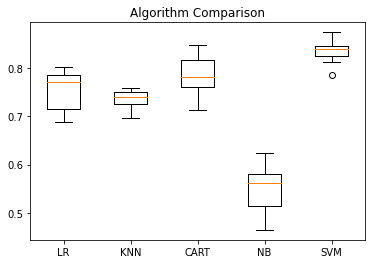

In [88]:
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

#### SVM

In [74]:
model = SVC(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

In [75]:
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.7583333333333333
[[352   8]
 [108  12]]
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       360
           1       0.60      0.10      0.17       120

    accuracy                           0.76       480
   macro avg       0.68      0.54      0.51       480
weighted avg       0.72      0.76      0.69       480



#### LR

In [84]:
model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

In [85]:
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.75
[[331  29]
 [ 91  29]]
              precision    recall  f1-score   support

           0       0.78      0.92      0.85       360
           1       0.50      0.24      0.33       120

    accuracy                           0.75       480
   macro avg       0.64      0.58      0.59       480
weighted avg       0.71      0.75      0.72       480



#### CART

In [86]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

In [87]:
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.7895833333333333
[[296  64]
 [ 37  83]]
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       360
           1       0.56      0.69      0.62       120

    accuracy                           0.79       480
   macro avg       0.73      0.76      0.74       480
weighted avg       0.81      0.79      0.80       480



## Caso 2

Caso 2:
Utilizzo le seguenti colonne di attributi per l'analisi:
- 'gender'
- 'heart_disease'
- 'ever_married'
- 'work_type'
- 'residence_type'
- 'smoking_status'
- 'stroke'
- 'bmi'
- 'avg_glucose_level'
- 'age'

NB: in questo caso utilizzo le colonne 'bmi', 'avg_glucose_level' e 'age' che hanno dei valori puntuali ed escludo i loro corrispettivi gruppi 'bmi_group', 'glucose_group' e 'age_group'.

In [77]:
X = resampled[['gender', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'stroke', 'bmi', 'avg_glucose_level', 'age']]
y = resampled['hypertension']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.30, random_state=1, shuffle=True, stratify=y)

### Risultati della classificazione

In [78]:
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.754464 (0.038351)
KNN: 0.736607 (0.019253)
CART: 0.783036 (0.039740)
NB: 0.549107 (0.049431)
SVM: 0.834821 (0.022676)


Come nel caso 1, la SVM è quella con l'accuracy più alta.
Plotto un boxplot per comparare le performance dei modelli.

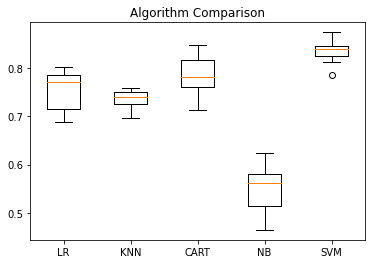

In [79]:
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [80]:
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.7583333333333333
[[352   8]
 [108  12]]
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       360
           1       0.60      0.10      0.17       120

    accuracy                           0.76       480
   macro avg       0.68      0.54      0.51       480
weighted avg       0.72      0.76      0.69       480



## Commento
La confusion matrix mostra come la predizione sia molto influenzata dalla distribuzione del dataset, infatti si può notare che, in entrambi i casi, il numero più alto dovuto alle misclassificazioni è da attribuirsi al numero di falsi negativi. Questo può essere spiegato dal fatto che la parte più importante dei campioni utilizzati presenta un target negativo e quindi è più facile classificare un nuovo campione all'interno di quella classe.
La possibile differenza tra il caso 1 e il caso 2 è da attribuirsi all'utilizzo di attributi categorici rispetto a valori numerici.